# Задание

Оценить, меняется ли физическая активность пользователей после установки sweatcoin app. 

В датасете собраны данные по дневным шагам сэмпла пользователей (в диапазоне +- 2 недели от даты регистрации)  
user_id - уникальный id пользователя  
platform - платформа девайса  
reg_date - дата регистрации пользователя  
steps_date - дата шагов  
steps - количество шагов  

Результат - jupyter notebook с анализом

In [32]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("test_task.csv", index_col=0)
df.head()

,user_id,platform,reg_date,steps_date,steps
0,41785284,IOS,2021-04-21,2021-04-13,458
1,41792465,IOS,2021-04-21,2021-04-13,5750
2,41494466,IOS,2021-03-28,2021-04-01,5635
3,41583452,IOS,2021-04-02,2021-04-01,1840
4,41637532,IOS,2021-04-07,2021-04-01,3127


Посмотрим на данные

In [3]:
df.dtypes

user_id        int64
platform      object
reg_date      object
steps_date    object
steps          int64
dtype: object

In [4]:
df.reg_date = pd.to_datetime(df.reg_date)
df.steps_date = pd.to_datetime(df.steps_date)

In [5]:
len(df)

81549

In [6]:
# количество польхователей
user_count = df['user_id'].nunique()
user_count

3531

In [7]:
set(df.platform)

{'ANDROID', 'IOS', nan}

In [8]:
df[df.platform.isna()].groupby('user_id').agg({'steps': 'sum'})

,steps
user_id,
40971110,21201
41232611,124138
41316658,132556
41393245,123183
41580994,625


In [9]:
# проверим, есть ли данные по пользователем с неизвестной платформы среди тех у кого платформа известна
pd.merge(
    left=df[df.platform.isna()],
    right=df[~df.platform.isna()],
    on='user_id'
)

,user_id,platform_x,reg_date_x,steps_date_x,steps_x,platform_y,reg_date_y,steps_date_y,steps_y


In [10]:
# данные с неизвестной платформы исключим для точности выводов
df = df[~df.platform.isna()]

In [11]:
df[df.steps_date.isna()]

,user_id,platform,reg_date,steps_date,steps


In [12]:
df[df.reg_date.isna()]

,user_id,platform,reg_date,steps_date,steps


In [13]:
df['diff_day'] = (df['steps_date'] - df['reg_date']).dt.days
df

,user_id,platform,reg_date,steps_date,steps,diff_day
0,41785284,IOS,2021-04-21,2021-04-13,458,-8
1,41792465,IOS,2021-04-21,2021-04-13,5750,-8
2,41494466,IOS,2021-03-28,2021-04-01,5635,4
3,41583452,IOS,2021-04-02,2021-04-01,1840,-1
4,41637532,IOS,2021-04-07,2021-04-01,3127,-6
...,...,...,...,...,...,...
81544,40888496,IOS,2021-01-29,2021-02-07,350,9
81545,41010128,ANDROID,2021-02-11,2021-02-07,0,-4
81546,40741168,IOS,2021-01-15,2021-01-02,10292,-13
81547,40736310,ANDROID,2021-01-15,2021-01-02,0,-13


Посмотрим на распределение пользователей по количеству известных дней активности. Чтобы понимать на сколько полные данные.

In [78]:
def plot_users_by_dates_distribution(df: pd.DataFrame) -> None:
    plot_df = df.groupby('user_id').agg({'steps_date': 'count'}).reset_index()
    plot_df = plot_df.groupby('steps_date').agg({'user_id': 'count'}).reset_index()

    fig = px.bar(plot_df, x='steps_date', y='user_id')
    fig.show("svg", width = 1500)


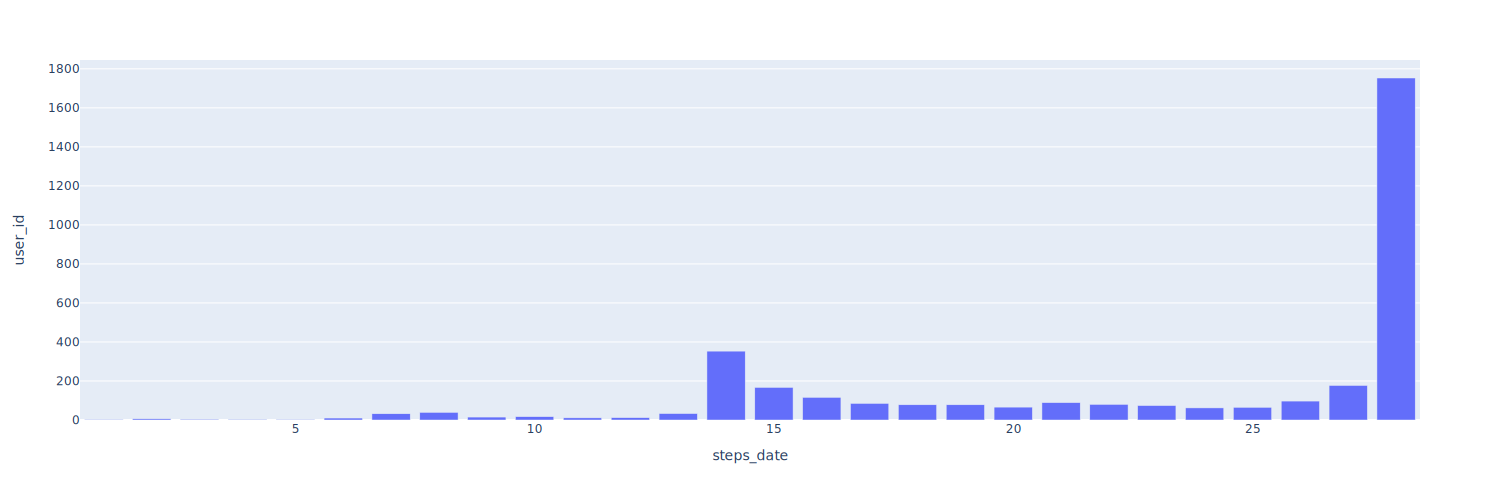

In [79]:
plot_users_by_dates_distribution(df)

У 50% пользователей имеется данные за полные 4 недели. Но при беглом осмотре данных я заметила, что для некоторых пользователей имеются дни с 0 количеством шагов - исключим их.

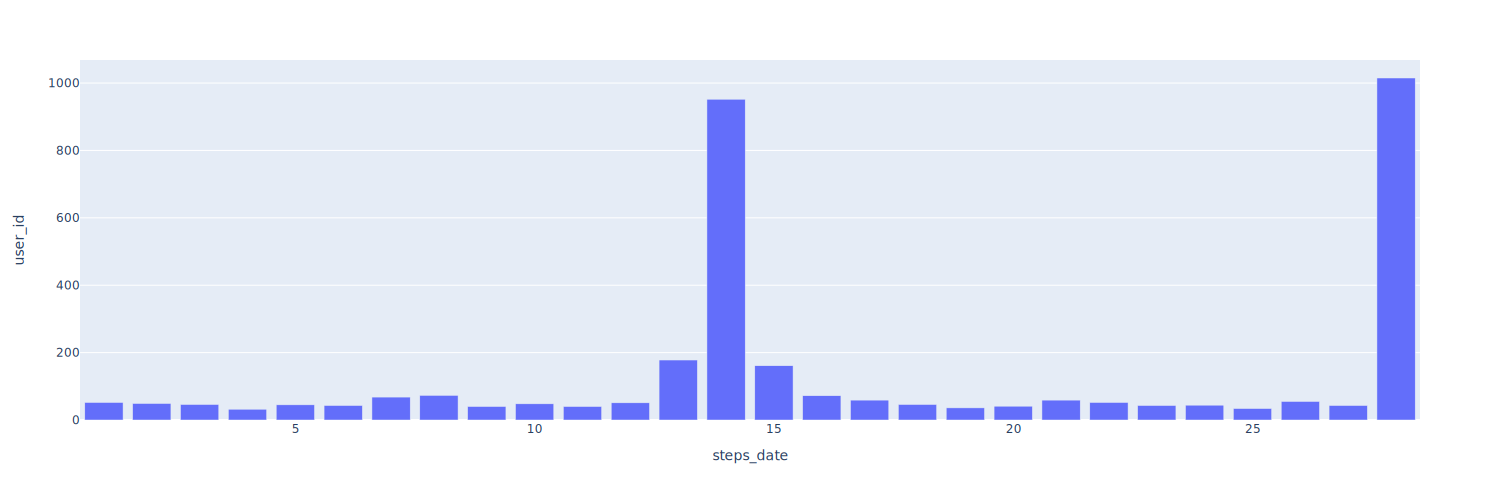

In [80]:
plot_users_by_dates_distribution(df[df.steps > 0])

Таким образом, пользователей с не нулевыми данными за все 28 дней осталось 30% от выборки. Кажется это именно те пользователи, которые помогут ответить нам на вопрос, как изменилась их физическая активность после установки приложения.

Для оценки изменения физической активности буду оценивать то как поменялось среднее количество шагов в день на пользователя после установки приложения. Для наглядности во время анализа будем визуализировать данные.

In [81]:
def print_avg_steps_distribution(df: pd.DataFrame) -> None:
    printed_df = df.groupby('diff_day').agg({'user_id': 'nunique', 'steps': 'sum'}).reset_index()
    printed_df['avg_steps'] = printed_df['steps'] / printed_df['user_id']

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=printed_df["diff_day"], 
            y=printed_df["user_id"], 
            mode="lines+text",
            text=printed_df["user_id"], 
            name='Count users',
            textposition="top center"
        )
    )
    fig.add_bar(x=printed_df["diff_day"], y=printed_df["avg_steps"], name="Avg steps per day")
    fig.show("svg", width = 1500)

    print( f" Изменение среднего количества шагов - {(printed_df[printed_df.diff_day >= 0]['avg_steps'].mean() / printed_df[printed_df.diff_day < 0]['avg_steps'].mean() - 1) * 100} %")
    print( f" Изменение абсолютного количества шагов - {(printed_df[printed_df.diff_day >= 0]['steps'].sum() / printed_df[printed_df.diff_day < 0]['steps'].sum() - 1) * 100} %")
    print( f" Изменение количества пользователей - {(len(set(df[df.diff_day >= 0]['user_id'])) / len(set(df[df.diff_day < 0]['user_id'])) - 1) * 100} %")

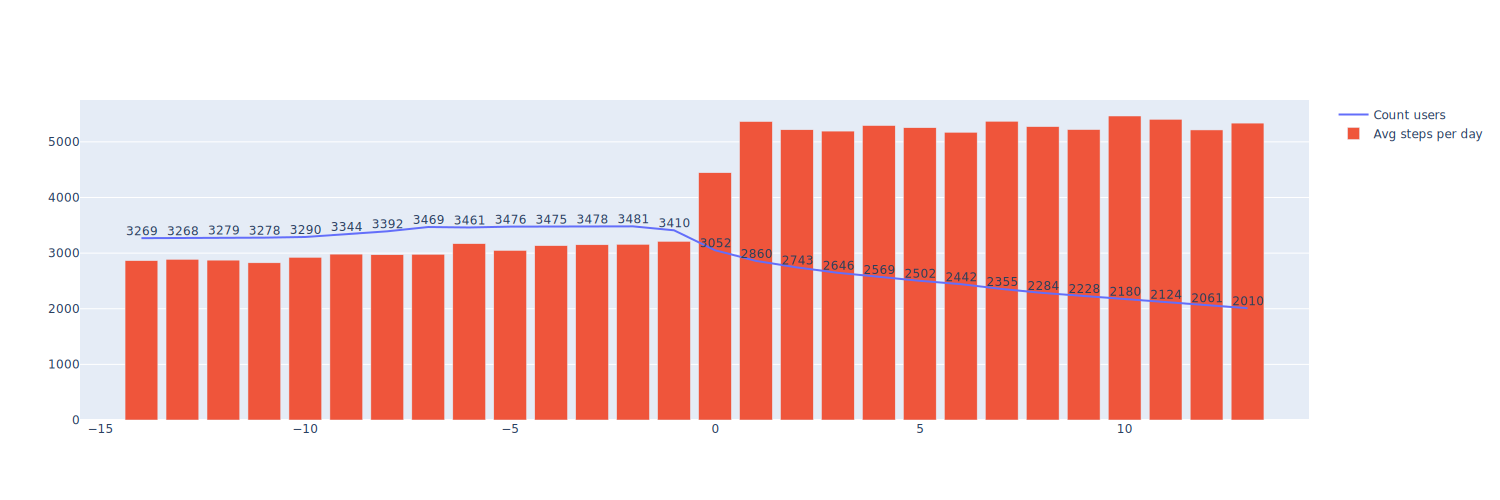

 Изменение среднего количества шагов - 73.61063350431245 %
 Изменение абсолютного количества шагов - 24.281732209885966 %
 Изменение количества пользователей - -12.720546385885035 %


In [82]:
# all platforms
print_avg_steps_distribution(df)

На первый взгляд мы видим значительный рост среднего количества шагов в день с 3 000 до 5 000. Но так же видно сокращение количества людей, по которым мы имеем измерения. Плюс, когда мы строили распределение, мы заметили, что у большого числа людей наблюдаются нулевые значения в примерно половине дней. Эти нулевые значения могут быть сконцентрированы как раз в период до установки приложения. Посмотрим на тот же самый график, но исключив нули.

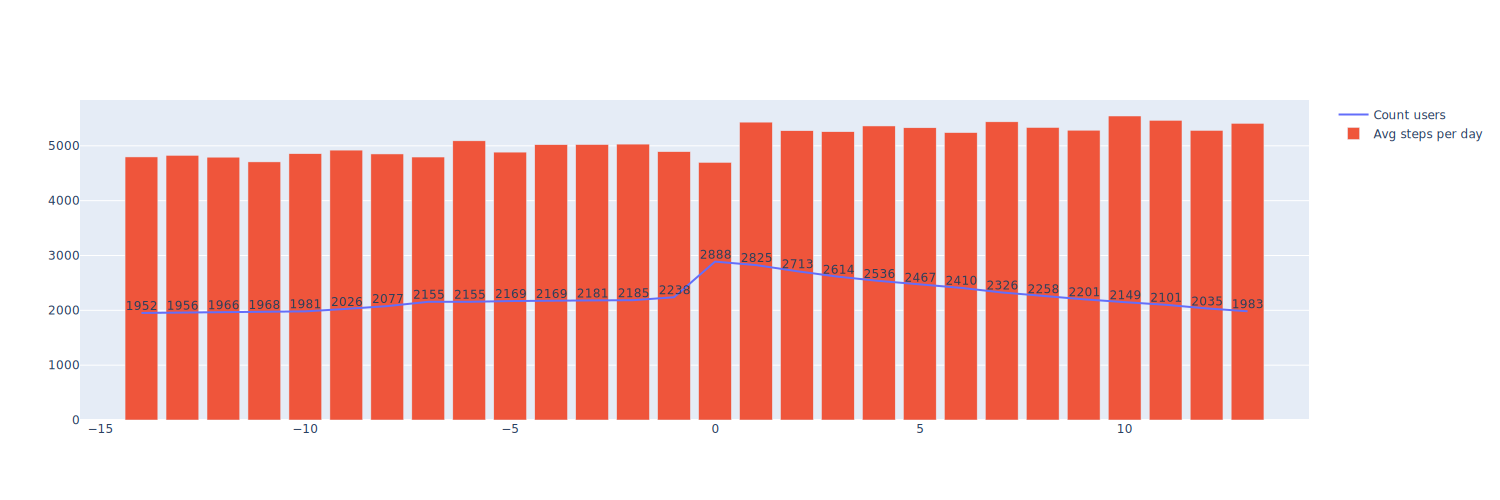

 Изменение среднего количества шагов - 8.551915721404878 %
 Изменение абсолютного количества шагов - 24.281732209885966 %
 Изменение количества пользователей - 33.391684901531725 %


In [83]:
print_avg_steps_distribution(df[df.steps > 0])

Результаты значительно поменялись. Количество людей в левой части графика сократилось сильнее, чем в правой. Что может натолкнуть на мысль что у этих людей не трекались шаги до установки приложения. Но мы не можем полагаться на такие результаты, так как для части людей мы оцениваем только их активность после установки приложение и просто исключили их данные (так как они 0 и все равно никакой нагрузки для нас не несут) за период до установки приложения. 
Попробуем идентифицировать ошибку и продолжим анализ после этого.

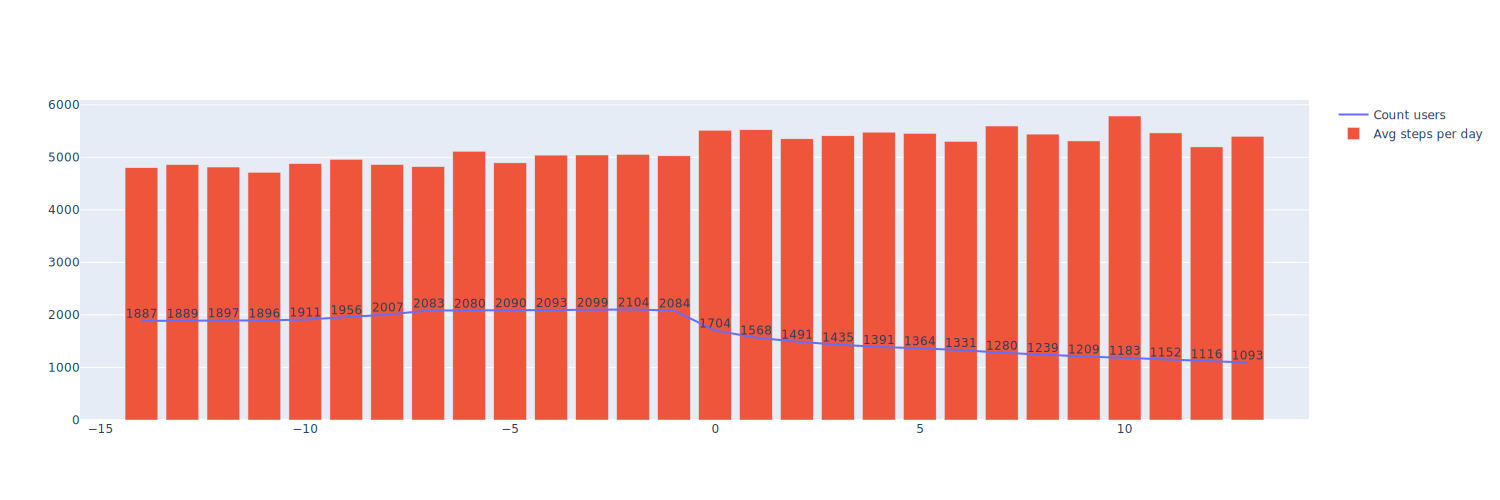

 Изменение среднего количества шагов - 10.654347927412221 %
 Изменение абсолютного количества шагов - -26.88789730903608 %
 Изменение количества пользователей - -19.42479962281942 %


In [84]:
#iOS
print_avg_steps_distribution(df[df.platform == 'IOS'])

У пользователей ios не наблюдается резкое изменение количества шагов - разтет на 10 % . Но при этом падает количество пользователей. При чем за день до установки людей больше чем в день установки, что похоже на ошибку. Но так же количество людей со дня устнановки уменьшается на 35% - кажется что люди после установки приложения в течении 14 дней его удаляют.

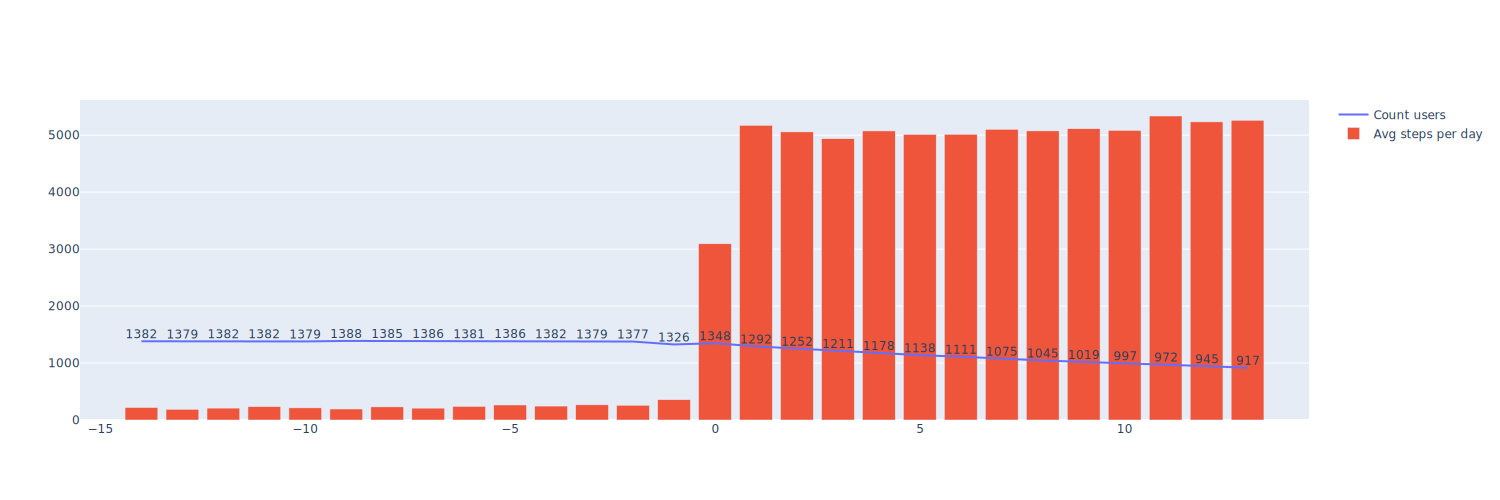

 Изменение среднего количества шагов - 1994.007845499934 %
 Изменение абсолютного количества шагов - 1572.1049982247407 %
 Изменение количества пользователей - -2.5125628140703515 %


In [85]:
#android
print_avg_steps_distribution(df[df.platform == 'ANDROID'])

Как же хорошо растет физическая активность пользователей Андроид! Но больше похоже на ошибку.  
Похоже, что на платформе Андроид до дня регистрации у многих пользователей не трекалась активность по шагам. Такая разница между платформами, скорее всего, обусловлена тем, что на платформе iOS трекинг физической активности включен по умолчанию и приложение Helth установлено по умолчанию. А на платформе Андроид такую функцию нужно включать самостоятельно, поэтому мы видим такую сильно заниженную активность до установки приложения. Таких пользователей для оценки разницы активности до и после установки использовать лучше не стоит.
Так же видно снижение количества пользователей с 1348 в день регистрации до 917 (-32%).

Такие данные, как по пользователям Андроид, не позволят нам сделать правильный вывод о том, менялась ли физическая активность или нет, так как до установки у большинства пользователей ее просто не было по данным. Попробуем сначала очистить датасет от явных выбросов (исключим значения выше 0.99 квантиля и нижк 0.01 квантиля)

## 1 Убрать явные выбросы из датасета

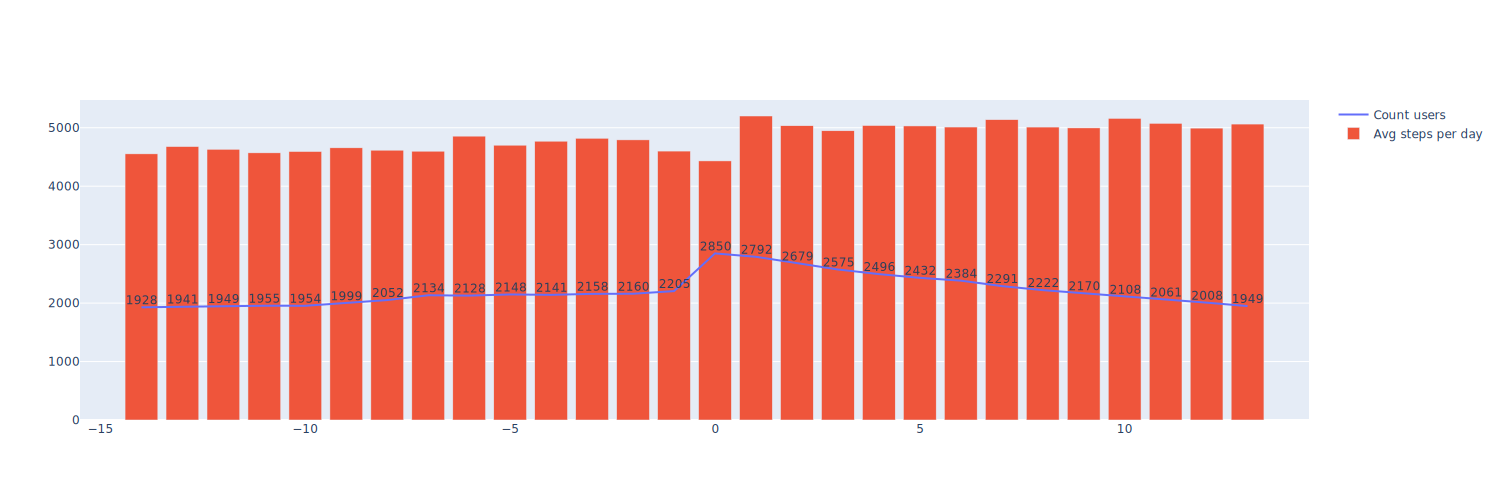

 Изменение среднего количества шагов - 7.178139058850452 %
 Изменение абсолютного количества шагов - 22.375166533199 %
 Изменение количества пользователей - 33.274956217162874 %


In [86]:
q_low = df["steps"].quantile(0.01)
q_hi  = df["steps"].quantile(0.99)

df_filtered = df[(df["steps"] < q_hi) & (df["steps"] > q_low)]
print_avg_steps_distribution(df_filtered)

Выглядит интереснее. Но я учла только выбросы всего датасета, а не выбросы внутри пользовательской активности, что могла удалить какие то полезные данные - ведь у разных людей может быть кардинально разная активность. Изменим подход на удаление выбросов для каждого пользователя а не для всего датасета.

## 2 Убираем выбросы для каждого пользователя

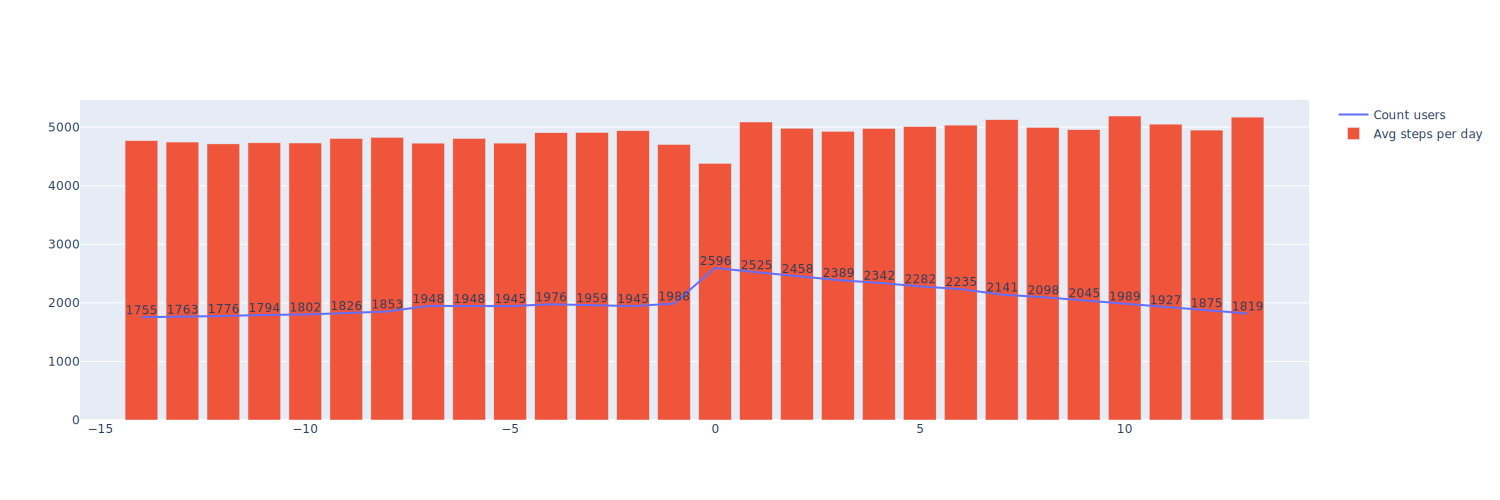

 Изменение среднего количества шагов - 4.182888634633053 %
 Изменение абсолютного количества шагов - 21.4923417761552 %
 Изменение количества пользователей - 30.911492734478195 %


In [87]:
df_filtered_each_users = pd.DataFrame()

for u in set(df.user_id):
    cycle_df = df[df.user_id == u]

    q_low = cycle_df["steps"].quantile(0.01)
    q_hi  = cycle_df["steps"].quantile(0.99)

    f_cycle_df = cycle_df[(cycle_df["steps"] < q_hi) & (cycle_df["steps"] > q_low)]
    df_filtered_each_users = pd.concat([df_filtered_each_users, f_cycle_df], ignore_index=True)

print_avg_steps_distribution(df_filtered_each_users)

Но у нас могло быть разное поведение по активности до и после установки приложения. Можно попробовать оценить на выбросы отдельно левую и отдельно правую части.

## 3 Убираем выбросы у пользователя отдельно до установки и после

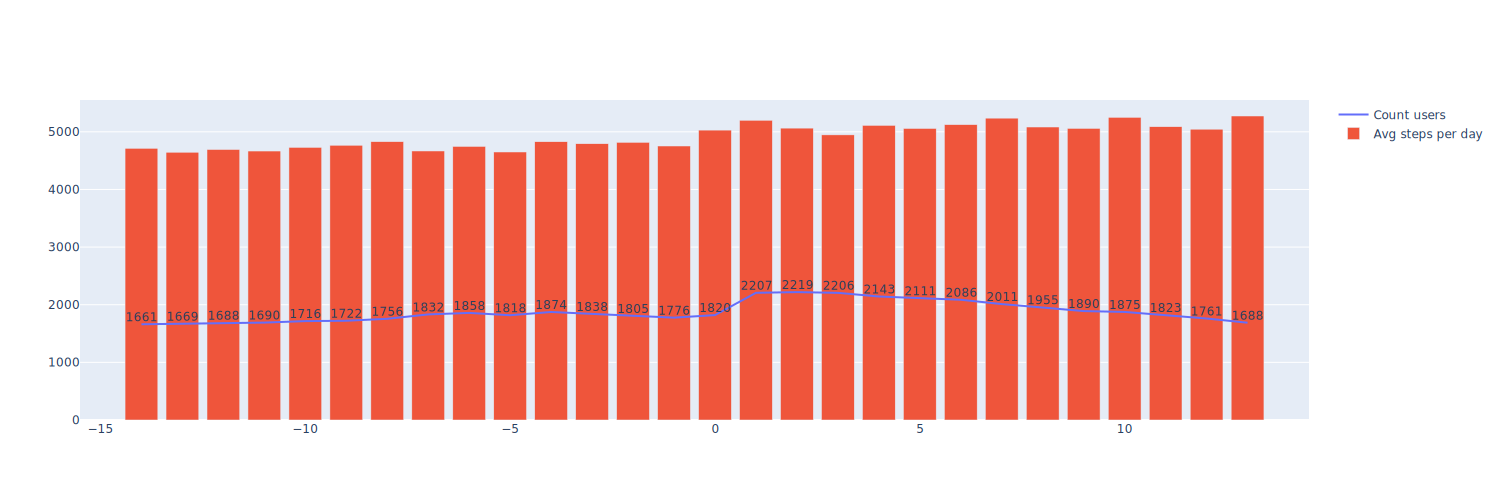

 Изменение среднего количества шагов - 7.952980866976711 %
 Изменение абсолютного количества шагов - 21.38929893355741 %
 Изменение количества пользователей - 25.034137460172957 %


In [88]:
def remove_anomalies(df: pd.DataFrame) -> pd.DataFrame:
    q_low = df["steps"].quantile(0.01)
    q_hi  = df["steps"].quantile(0.99)

    return df[(df["steps"] < q_hi) & (df["steps"] > q_low)]


df_filtered_each_users = pd.DataFrame()

for u in set(df.user_id):
    cycle_df = df[df.user_id == u]

    df_filtered_each_users = pd.concat([df_filtered_each_users, remove_anomalies(cycle_df[cycle_df.diff_day < 0])], ignore_index=True)
    df_filtered_each_users = pd.concat([df_filtered_each_users, remove_anomalies(cycle_df[cycle_df.diff_day >= 0])], ignore_index=True)

print_avg_steps_distribution(df_filtered_each_users)

Удалением выбросов мы приводим выборку к более нормальному состоянию, но тем самым мы можем оставить среди всех дней активности пользователя только один, что не хорошо, так как 1 день из 28 может некорректно сказаться на общей картине. Попробую оставить в выборке только тех людей у которых есть данные больше чем по 3/4 всех дней.

## 4 Оставить людей только с достаточным количеством дней активности

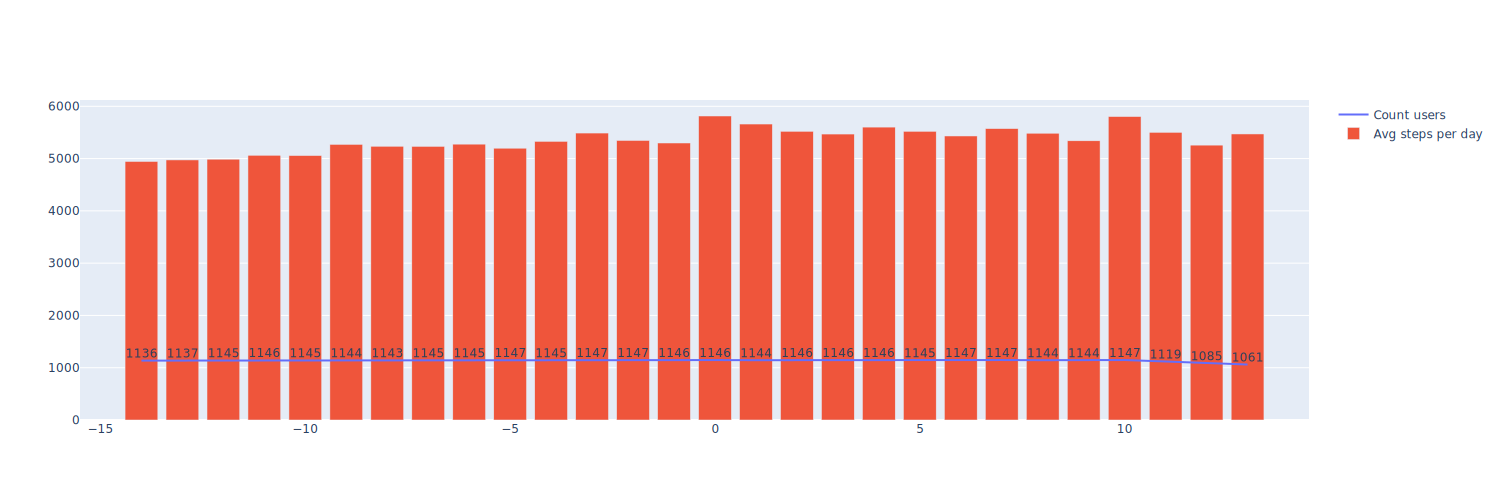

 Изменение среднего количества шагов - 6.53131609528137 %
 Изменение абсолютного количества шагов - 5.549074103302298 %
 Изменение количества пользователей - 0.0 %


In [89]:
good_users = []

for u in set(df.user_id):
    c_df = pd.DataFrame()
    cycle_df = df[df.user_id == u]

    c_df = pd.concat([c_df, remove_anomalies(cycle_df[cycle_df.diff_day < 0])], ignore_index=True)
    c_df = pd.concat([c_df, remove_anomalies(cycle_df[cycle_df.diff_day >= 0])], ignore_index=True)

    if len(c_df.diff_day.unique()) >= 28 * 0.75:
        good_users.append(u)

print_avg_steps_distribution(df[df.user_id.isin(good_users)])

Ну и последний способ. Идея такая - что еслии нам не хватает немного дней слева или справа от дня установки - достроить эти данные по медиане, чтобы не терять много клиентов.

## 5 Достроим недостающие данные

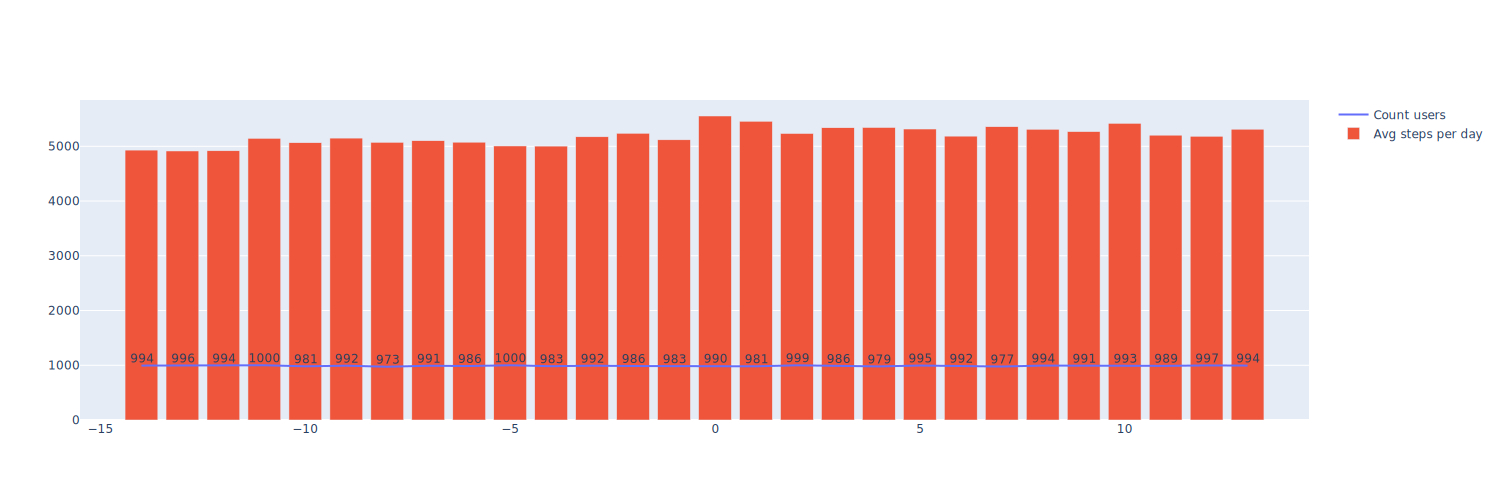

 Изменение среднего количества шагов - 5.034775443061124 %
 Изменение абсолютного количества шагов - 5.0781676930247155 %
 Изменение количества пользователей - 0.0 %


In [90]:
# отдельно смотрим до и после
# если нет 25% данных то достраиваем медианой
# иначе это не наш человек
# если в обоих случаях достроилось
# еще раз полные данные прогоняем через детоктор анамалий, смотрим сколько данных осталось и уже принимаем решение оставлять или нет

def added_missing_values(df: pd.DataFrame, draft_df: pd.DataFrame) -> pd.DataFrame:
    m = df['steps'].median()
    f_cycle_df_additional = pd.merge(
        left=draft_df,
        right=df,
        on='diff_day',
        how='left'
    )
    f_cycle_df_additional = f_cycle_df_additional[f_cycle_df_additional.user_id.isna()]
    f_cycle_df_additional.user_id = u
    f_cycle_df_additional.steps = m
    return pd.concat([df, f_cycle_df_additional], ignore_index=True)


df_filtered_each_users = pd.DataFrame()
draft_df = pd.DataFrame({
    'diff_day': [-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13]
})
border_date = int(14 * 0.75)

for u in set(df.user_id):
    c_df = pd.DataFrame()
    cycle_df = df[df.user_id == u]

    f_cycle_df = remove_anomalies(cycle_df[cycle_df.diff_day < 0])
    if len(f_cycle_df.diff_day.unique()) <= border_date:
        continue
    c_df = pd.concat([c_df, added_missing_values(f_cycle_df, draft_df[draft_df.diff_day < 0])], ignore_index=True)

    f_cycle_df = f_cycle_df = remove_anomalies(cycle_df[cycle_df.diff_day >= 0])
    if len(f_cycle_df.diff_day.unique()) <= border_date:
        continue

    c_df = pd.concat([c_df, added_missing_values(f_cycle_df, draft_df[draft_df.diff_day >= 0])], ignore_index=True)

    q_low = c_df["steps"].quantile(0.01)
    q_hi  = c_df["steps"].quantile(0.99)
    c_df = c_df[(c_df["steps"] < q_hi) & (c_df["steps"] > q_low)]
    if len(c_df.diff_day.unique()) >= 28 * 0.75:
        df_filtered_each_users = pd.concat([c_df, df_filtered_each_users], ignore_index=True)


print_avg_steps_distribution(df_filtered_each_users)

Пользователей стало еще меньше, так как ужесточилось условие что и справа и слева от дня установки должно быть больше 75% дней.

Выводы:  
Данные очень не полные и по таким данным сложно как-то быстро оценить изменение активности пользователей. Из того что получилось вычистить или достроить видно, что активность незначительно повышается (5-8% при разным расчетах). Что еще интересно - это уменьшение количество пользователей после установки. Есть гипотеза, что они устанавливают приложение, пробуют, им что-то не нравится и они приложение удаляют. С чем то еще пропажу данных я не могу объяснить. У оставшихся пользователей не наблюдается прямо бурного прироста в активности, но небольшой прирост все таки есть.